This notebook recreates Fisg. 3b and c in Merdith et al. (2019) 'Rift and Plate Boundary Evolution across Two Supercontinent Cycles'. 

It loops through plate reconstructions and extracts the length of subduction zones thresholded by their proximity to continental crust, and also rift length after Brune et al. (2017). The rift database for the Neoproterozoic was submitted as part of this manuscript and extends from 1000 to 450 Ma. It is not exhaustive and in many cases the lengths of each rift are inferred partly be geology and partly by global kinmeatics. For 450—0 Ma we use the database of Şengör and Natal'in (2001).


References

Brune, S., Williams, S.E. and Müller, R.D., 2017. Potential links between continental rifting, CO 2 degassing and climate change through time. Nature Geoscience, 10(12), p.941.

Domeier, M., 2016. A plate tectonic scenario for the Iapetus and Rheic oceans. Gondwana Research, 36, pp.275–295.

Domeier, M., 2018. Early Paleozoic tectonics of Asia: towards a full-plate model. Geoscience Frontiers, 9(3), pp.789–862.

Matthews, K.J., Maloney, K.T., Zahirovic, S., Williams, S.E., Seton, M. and Müller, R.D., 2016. Global plate boundary evolution and kinematics since the late Paleozoic. Global and Planetary Change, 146, pp.226–250.

Merdith, A.S., Collins, A.S., Williams, S.E., Pisarevsky, S., Foden, J.D., Archibald, D.B., Blades, M.L., Alessio, B.L., Armistead, S., Plavsa, D., Clark, C., and Müller, R.D. 2017. A full-plate global reconstruction of the Neoproterozoic. Gondwana Research, 50, pp.84–134.

Merdith, A.S., Williams, S.E., Brune, S., Collins, A.S. and Müller, R.D. 2019. Rift and Plate Boundary Evolution across Two Supercontinent Cycles. Global and Planetary Change, 173, pp.1–14 

Şengör, A.C. and Natal'in, B.A., 2001. Rifts of the world. Mantle plumes: their identification through time. Geological Society of America Special Papers, 352, pp.389-482.

In [21]:
import pygplates
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
from labellines import labelLine, labelLines
from create_gpml import create_gpml_regular_long_lat_mesh
from skimage import measure
import points_in_polygons
import itertools
import csv
%matplotlib inline

In [ ]:
def GetRiftLength(rift_name):
    length = [] 
    for time in np.arange(450,1010,10):
        rift_length_total = 0.
        rift_length = rift.get_geometry().get_arc_length()
        individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
        tmp_valid_time = np.arange(int(rift.get_valid_time()[1]),
                                   int(rift.get_description())+1, 1)
        #print rift.get_valid_time()[0] > time
        #print int(rift.get_description()) < time
        if (rift.get_valid_time()[0] > time) and (int(rift.get_description()) < time):
            rift_length_total+=individual_rift_length_kms
        length.append(rift_length_total)
    return length

In [ ]:
def run_grid_pip(time,points,polygons,rotation_model):
    
    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)
    
    rpolygons = []
    for polygon in reconstructed_polygons:
        #print polygon
        #if polygon.get_reconstructed_geometry() == 'PolygonOnSphere':
        if polygon.get_reconstructed_geometry():
            #print polygon.get_reconstructed_geometry()
            rpolygons.append(polygon.get_reconstructed_geometry())


    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    bi = np.array(zval).reshape(181,361)
    
    return bi


In [ ]:
 def lamo(bi):
    #
    #so this sucks
    #essentialy at time slices where the supercontinent polygon covers all of one
    #side of our array, python can't tell which is in and which is out
    #so we arbitarilly buffer the size of our arrays below to make them one entry bigger
    #so we can get what we need, then we undo it later
    #

    #pad
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3,0.1, fully_connected='low')
    contour_polygons = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
    
    return contour_polygons

In [5]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_GPC/Sample_data/'

#Matthews et al. (2016)
Mat16_rotation_model = pygplates.RotationModel('%sMat16_410-0Ma.rot' % basedir)
Mat16_polygons = pygplates.FeatureCollection('%sMat16_PresentDay_ContinentalPolygons.gpml' % basedir)
Mat16_topologies = ['%sMat16_Mesozoic-Cenozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_Paleozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_TopologyBuildingBlocks.gpml' % basedir]
Mat16_COBs = pygplates.FeatureCollection('%sMat16_COBs.gpml' % basedir)

#Domeier models
Dom18_rotation_model = pygplates.RotationModel('%sDom18_merge-Rotation_ASM.rot' % basedir)
Dom18_polygons = pygplates.FeatureCollection('%sDom18_merge-Land_ASM.gpml' % basedir)
Dom18_topologies = ['%sDom18_merge-Ridges_ASM.gpml' % basedir,
                  '%sDom18_merge-Topologies_ASM.gpml' % basedir,
                  '%sDom18_merge-Transforms_ASM.gpml' % basedir,
                  '%sDom18_merge-Trenches_ASM.gpml' % basedir,
                  '%sDom18_merge-ArbitaryLines_ASM.gpml' % basedir]
Dom_COBs = pygplates.FeatureCollection('%sDom18_merge-COBs.gpml' % basedir)

#Merdith model
Mer17_rotation_model = pygplates.RotationModel('%sMer17_rotations.rot' % basedir)
Mer17_polygons = pygplates.FeatureCollection('%sMer17_polygons.gpml' % basedir)
Mer17_topologies = ['%sMer17_Transforms.gpml' % basedir,
                  '%sMer17_Topologies.gpml' % basedir,
                  '%sMer17_Divergence.gpml' % basedir,
                  '%sMer17_Convergence.gpml' % basedir]
Mer17_COBs = pygplates.FeatureCollection('%sMer17_COBs.gpml' % basedir)

#load rift files
Mer19_rifts = pygplates.FeatureCollection('%sMer19_Neoprot_Rifts.gpml' % basedir)
Dom18_rifts = pygplates.FeatureCollection('%sDom18_Palaeozoic_Rifts.gpml' % basedir)
palaeozoic_rifts = pd.read_csv('%sSengor_RiftLengthBinned.csv' % basedir, header=None)

#tidy palaeozoic data frames
#tidy dataframe, rename columns of palaezoic rift length
new_cols = ['time','length']
palaeozoic_rifts.columns = new_cols

palaeozoic_rifts_list = palaeozoic_rifts['length'].values.tolist() #extract as list
palaeozoic_rifts_10myr = palaeozoic_rifts_list[0::10] #get 10 Ma increments

reversed_palaeozoic_rifts = palaeozoic_rifts_10myr[::-1] #reverse list so that youngest time is at the bottom

multipoints = create_gpml_regular_long_lat_mesh(1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()

In [6]:
#this confirms that all features within our COB terranes are actually polygons and not multipoints in disguise
polygons = []
for feature in Mat16_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Mat16_COBs = pygplates.FeatureCollection(polygons)

polygons = []
for feature in Dom_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Dom18_COBs = pygplates.FeatureCollection(polygons)

polygons = []
for feature in Mer17_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Mer17_COBs = pygplates.FeatureCollection(polygons)

Extract Continental Arc length over time at distance different increments from nearest COB

In [ ]:
distance_range = [100,150,200,15000]
total_arc_length = dict()

times = np.arange(0, 1010, 10)
for distance in distance_range:
    print distance
    total_arc_length[distance] = []

    for time in times:
        
        if time <= 410:
            COBs = Mat16_COBs
            rotations = Mat16_rotation_model
            topologies = Mat16_topologies
        elif time > 410 and time <= 500:
            COBs = Dom18_COBs
            rotations = Dom18_rotation_model
            topologies = Dom18_topologies
        else:
            COBs = Mer17_COBs
            rotations = Mer17_rotation_model
            topologies = Mer17_topologies
        
        contour_polygons = []

        bi = run_grid_pip(time,
                          points,
                          COBs,
                          rotations)
        
        contour_polygons = lamo(bi)
        
        resolved_topologies = []
        shared_boundary_sections = []
        all_tesselated_shared_sub_segment = []
        continental_arcs = []

        pygplates.resolve_topologies(topologies, 
                                     rotations,
                                     resolved_topologies,
                                     time,
                                     shared_boundary_sections)

        total_length = 0.

        for shared_boundary_section in shared_boundary_sections:

            if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

                for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                    tmp = shared_sub_segment.get_resolved_geometry()
                    tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.1))      

                    all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)

                    for segment in tesselated_shared_sub_segment.get_segments():
                        count = 0.
                        for COB in contour_polygons:
                            if COB.get_area()*pygplates.Earth.mean_radius_in_kms**2 > 500000:
                                distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                       COB)
                                distance_kms = distance_radians * pygplates.Earth.mean_radius_in_kms
                                if distance_kms < distance:
                                    total_length += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms
                                    count+=1.
                                    if count > 1:
                                        print 'Double-Dipping!!'

                                    break
        total_arc_length[distance].append(total_length)

In [ ]:
#determine oceanic arc length by subtracting our threshold from total
c = total_arc_length[15000]
d = total_arc_length[150]
e= []
for i,j in zip(c,d):
    e.append(i-j)
    
f = {'ocean':e[:]}
total_arc_length.update(f)
total_arc_length.keys()

In [ ]:
#plot arc length
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6),facecolor='w', edgecolor='k')
ax.plot(times, total_arc_length[100], linewidth=3, alpha=0.4, label='100 km threshold')
ax.plot(times, total_arc_length[150], linewidth=3, label='150 km threshold')
ax.set_xlim(1000,0)

In [27]:
#now we will save it out 
#a = total_arc_length
#
#with open('%scont_arc_length.pickle' % basedir, 'wb') as handle:
#    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

#and to open if previously saved
with open('%s/cont_arc_length.pickle' % basedir, 'rb') as handle:
    total_arc_length = pickle.load(handle)

In [40]:
#save csv
values = itertools.izip(times,
                        total_arc_length[100],
                        total_arc_length[150],
                        total_arc_length[200],
                        total_arc_length['ocean'])
                      
    
with open('%sarc_length_1000_0.csv' % basedir, mode='wb') as myfile:
    rift_writer = csv.writer(myfile, delimiter=',', quoting=csv.QUOTE_ALL)
    rift_writer.writerow(('time', 
                          '100_km',
                          '150_km',
                          '200_km',
                          'ocean'))
    
    for val in values:
        rift_writer.writerow(val)

Extract Rift Length from Neoproterozoic model, link to Phanerozoic Rift Length

In [10]:
rift_dict = {'Neoprot_rifts': Mer19_rifts,
             'palaeozoic_rifts': Dom18_rifts}

In [11]:
#extract total rift length through time for various files
#default rifts as best constrained by geology

total_rift_length = dict()

for rift_type, rift_lengths in rift_dict.items():
    print rift_type
    total_rift_length[rift_type] = []
    for time in range(460,1010,10):
        rift_length_total = 0.
        for rift in rift_lengths:
            rift_length = rift.get_geometry().get_arc_length()
            individual_rift_length_kms = rift_length * pygplates.Earth.mean_radius_in_kms
            tmp_valid_time = np.arange(int(rift.get_valid_time()[1]), int(rift.get_description())+1, 1)
            if (rift.get_valid_time()[0] >= time) and (int(rift.get_description()) <= time):
                rift_length_total+=individual_rift_length_kms

        total_rift_length[rift_type].append(rift_length_total)

palaeozoic_rifts
Neoprot_rifts


In [12]:
#organise rifts from 0-1000
for key in total_rift_length:
    tmp_list = []
    tmp_list.extend(palaeozoic_rifts_10myr)
    tmp_list.extend(total_rift_length[key])
    total_rift_length[key] = tmp_list

In [35]:
#save csv
values = itertools.izip(times,
                        total_rift_length['Neoprot_rifts'])
                      
    
with open('%srift_length_1000_0.csv' % basedir, mode='wb') as myfile:
    rift_writer = csv.writer(myfile, delimiter=',', quoting=csv.QUOTE_ALL)
    rift_writer.writerow(('time', 
                          'rift_length'))
    for val in values:
        rift_writer.writerow(val)

## Plotting everything

In [24]:
#to create a stack plot of just neoproterozoic rifts
total_length = []
rift_names = []
valid_times = []
for rift in rift_dict['Neoprot_rifts']:
    rift_names.append(rift.get_name())
    valid_times.append(rift.get_valid_time())
    length = GetRiftLength(rift)
    total_length.append(length)

/Users/Andrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  if __name__ == '__main__':


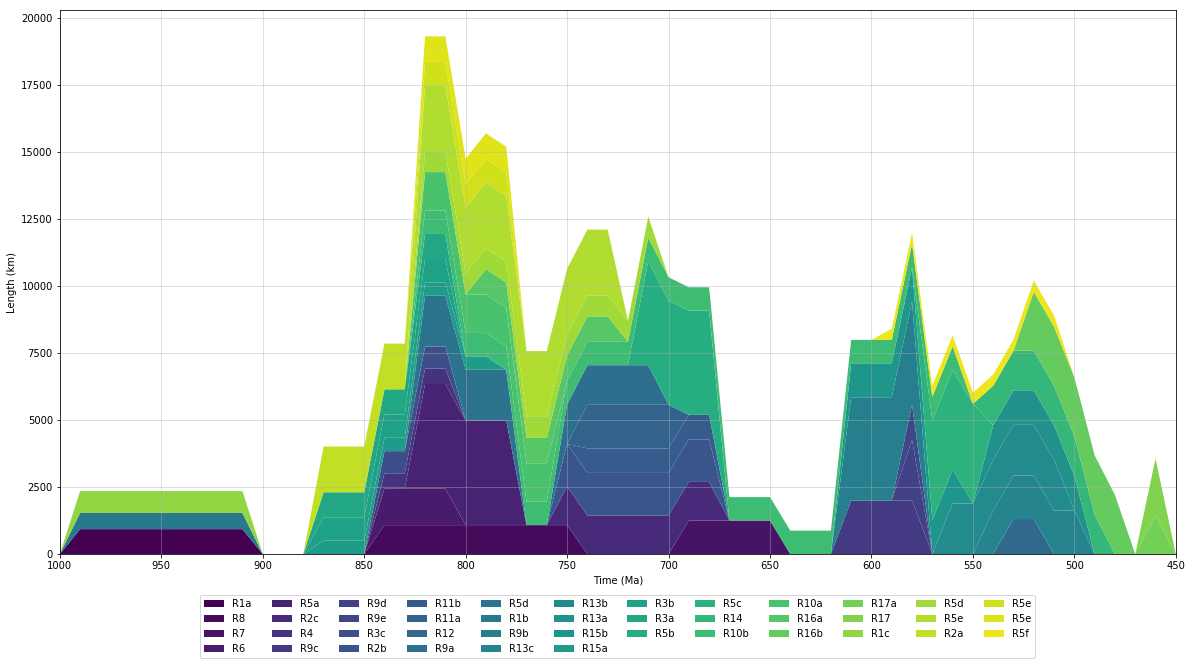

In [25]:
#stack plot of rift length from the Neoproterozoic
neoprot_plot_times = np.arange(450,1010,10)
num_colours = len(rift_names)
cm = plt.get_cmap('viridis')
cNorm = colors.Normalize(vmin=0, vmax=num_colours)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), facecolor='w', edgecolor='k')
ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(num_colours)])
ax.stackplot(neoprot_plot_times,total_length)
ax.set_xlim(1000,450)
ax.set_xticks(np.arange(450,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Length (km)')
ax.legend(rift_names, loc='lower center', ncol=12,bbox_to_anchor=(0.5,-0.2))

/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


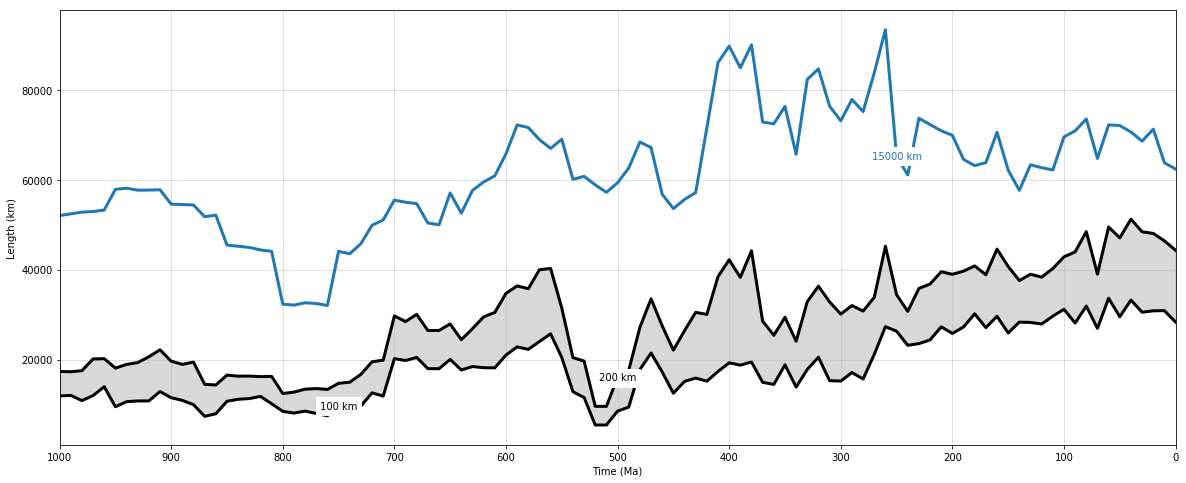

In [28]:
#just arc length
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8),facecolor='w', edgecolor='k')
ax.plot(times, total_arc_length[100], linewidth=3, color='k', label='100 km')
ax.plot(times, total_arc_length[200], linewidth=3, color='k', label='200 km')
ax.plot(times, total_arc_length[15000], linewidth=3, label='15000 km')
ax.fill_between(times, total_arc_length[100], total_arc_length[200], color='gray', alpha=0.3)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Length (km)')
ax.set_xticks(np.arange(0,1100,100))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
labelLines(plt.axes(ax).get_lines(),align=False)

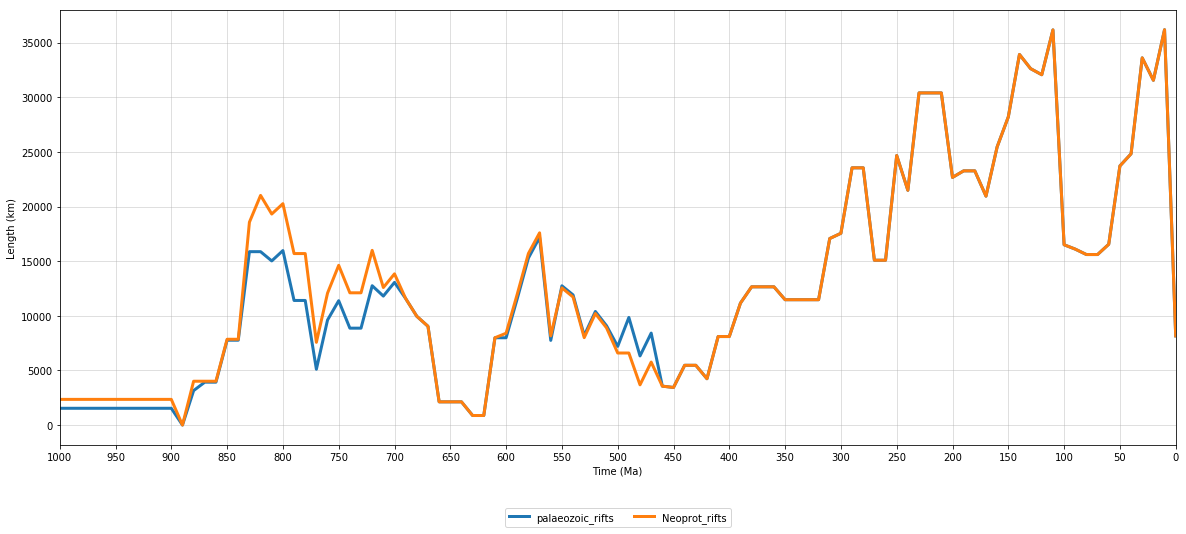

In [29]:
#plot just rift length
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
for data_labels, data_dict in total_rift_length.items():
    ax.plot(times, data_dict, label=data_labels, linewidth=3)
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Length (km)')
ax.set_xticks(np.arange(0,1050,50))
ax.xaxis.grid(True, alpha=.5)
ax.yaxis.grid(True, alpha=.5)
ax.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,-0.2))

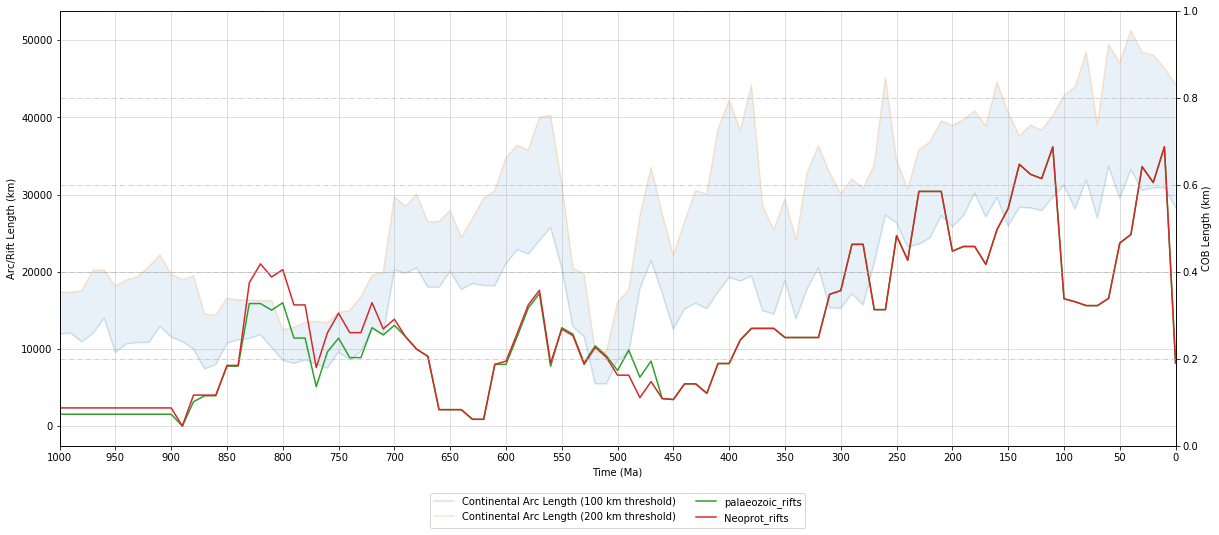

In [30]:
#plot everything (master version)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8),facecolor='w', edgecolor='k')
ax2 = ax1.twinx()
ax1.plot(times,total_arc_length[100], alpha=0.2, label='Continental Arc Length (100 km threshold)')
ax1.plot(times,total_arc_length[200], alpha=0.2, label='Continental Arc Length (200 km threshold)')
for data_labels, data_dict in total_rift_length.items():
    ax1.plot(times, data_dict, label=data_labels)
ax1.fill_between(times, total_arc_length[100], total_arc_length[200], alpha=0.1)
ax1.tick_params(axis='x')
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.set_xlim(1000,0)
ax1.set_xticks(np.arange(0,1050,50))
ax1.set_xlabel('Time (Ma)')
ax1.set_ylabel('Arc/Rift Length (km)')
ax2.set_ylabel('COB Length (km)')
ax1.xaxis.grid(True, alpha=.5)
ax1.yaxis.grid(True, alpha=.5)
ax2.yaxis.grid(True, alpha=.7, ls='-.')
ax1.legend(ncol=2,loc='lower center',bbox_to_anchor=(0.5,-0.2))
